# Probability Ninjas - Assignment 4
* Vipul Popat
* Saurabh Goel
* Vijay Sambhe
* Mark O'Brien
* Mike Nolan

## Description

Sales forecasting techniques allow companies to predict sales, and once a company has what it believes is an accurate estimate of future sales it can then quantify finance needs, estimate the quantity and cost of purchases of raw materials as well as determining production level.

A fundamental problem in sales forecasting is predicting if sales will increase or not. This is particularly difficult in case the sales of a given product exhibits seasonality. In time series data, seasonality is the presence of variations that occur at specific regular intervals and repeats regularly.
For example, the sales of ice cream will be higher in the warmer seasons and lower in the colder seasons.

The provided dataset contains past sales of a **multinational ice-cream** company that sells ice-creams in 120 different Countries. Each row in the dataset is a time-series: the input x is time (scaled and transformed in the interval [0,1]) and the output y represents the sales in one of the Country (this was also scaled and transformed). There are 120 rows (Countries).

#### Goal

Construct an algorithm that, for each Country:

1. removes the seasonal component in the time-series (if a seasonal component is present);
2. predicts if the non-seasonal component of sales is increasing or not. That is the prediction is binary: value=1 if the non-seasonal component is increasing; value=0 if the non-seasonal component is not increasing.

#### Remarks

1. Some time-series may not have a seasonal component. At low latitudes, there is not significant seasonal change.
2. The original time-series duration is unknown. Time is assumed to be normalised into the interval [0,1] (100 evenly spaced numbers in the interval [0,1])

## Evaluation

Submissions will be evaluated based on *Weighted accuracy*:

$$
WA = \frac{\sum_{i=1}^{n}\omega_{i} (y_i==\hat{y}_i)}{\sum_{i=1}^{n}\omega_{i}}
$$

where

$$
\begin{array}{ll}
\omega_i = 6 & \text{if } y_i=\hat{y}_i \text{ and } y_i=0 \\
\omega_i = 4 & \text{if } y_i=\hat{y}_i \text{ and } y_i=1 \\
\end{array}
$$

Note that, for the ice-cream company, predicting $0$ is more important than predicting $1$.

### Submission Format

The submission file should be in text format (.csv). The submission file must have the following format:

$$
\begin{array}{cc}
Id & Category\\
0 & 1\\
1 & 0\\
2 & 1\\
3 & 1\\
4 & 0\\
... & ...\\
\end{array}
$$

where _Id_ is the Id of the time-series (the first column of the dataset) and Category is your prediction for that time-series. Note again that the prediction is binary: value=1 if the non-seasonal component of the time-series is increasing; value=0 if the non-seasonal component is not increasing. Be sure that the values in the Id and Category column are integers (not float).

#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
from scipy.stats import multivariate_normal

import warnings
warnings.filterwarnings('ignore')

#### Load Dataset / Data Exploration

Here we load the `train.csv` dataset and take a look at the data contained in it.

In [2]:
data = pd.read_csv('./data/train.csv')
data.describe()

,Id,0,1,2,3,4,5,6,7,8,...,91,92,93,94,95,96,97,98,99,Category
count,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,...,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000
mean,157.000000,0.140018,0.116428,0.147523,0.166251,0.159290,0.154911,0.171788,0.163420,0.172034,...,0.563733,0.576017,0.572355,0.580488,0.599886,0.639733,0.631687,0.633445,0.670396,0.346667
std,21.794495,0.531072,0.533557,0.515018,0.513822,0.506893,0.501646,0.484376,0.499714,0.497433,...,0.742961,0.740551,0.764901,0.733439,0.786804,0.754772,0.783581,0.783238,0.775564,0.479113
min,120.000000,-1.044003,-0.994305,-0.885585,-0.761513,-0.717464,-0.757696,-0.578701,-0.647595,-0.474244,...,-0.218118,-0.130778,-0.242646,-0.238697,-0.183577,-0.199834,-0.194937,-0.300764,-0.150227,0.000000
25%,138.500000,-0.102221,-0.094447,-0.071158,-0.059394,-0.101118,-0.092047,-0.081801,-0.059817,-0.075092,...,0.027346,0.048706,0.028304,0.036863,0.017775,0.057197,0.025564,0.066313,0.064214,0.000000
50%,157.000000,0.051074,0.038222,0.050688,0.068801,0.057736,0.024308,0.044768,0.015566,0.001266,...,0.231157,0.202431,0.208260,0.193447,0.213291,0.220146,0.176925,0.207900,0.247912,0.000000
75%,175.500000,0.244199,0.212144,0.250240,0.215488,0.184486,0.189067,0.149534,0.138871,0.132242,...,0.790795,0.870270,0.924093,0.946616,1.148687,1.114469,1.114301,1.151813,1.212613,1.000000
max,194.000000,1.159202,1.139233,1.249389,1.217042,1.243997,1.208698,1.294389,1.222726,1.351073,...,2.098946,2.051068,2.155725,2.075734,2.084094,2.101399,2.219500,2.115519,2.118771,1.000000


In [3]:
data.head(10)

,Id,0,1,2,3,4,5,6,7,8,...,91,92,93,94,95,96,97,98,99,Category
0,120,0.147298,-0.142030,0.091737,-0.151707,0.060124,0.186191,-0.021298,-0.025636,0.061044,...,-0.218118,0.011316,0.079464,-0.010833,-0.053485,0.046450,-0.008333,0.168574,0.123273,0
1,121,0.115710,0.105061,0.038446,0.166711,-0.113913,0.004528,-0.006954,-0.140054,0.154231,...,0.021526,0.069009,-0.060343,0.094007,0.049558,0.112370,0.020398,0.039687,0.217384,0
2,122,-0.548826,-0.466551,-0.650890,-0.553450,-0.449101,-0.496902,-0.464860,-0.394458,-0.271801,...,0.057272,0.088062,-0.069730,0.168498,0.109672,0.202808,-0.019942,0.058902,0.053936,0
3,123,0.192618,0.291155,-0.042980,0.146483,0.015390,0.019394,-0.005577,-0.048682,0.025772,...,0.140831,0.257332,0.262786,0.351659,0.213291,0.251077,0.190920,0.251743,0.337730,1
4,124,0.075706,0.069045,-0.019818,0.068801,-0.226501,0.011658,0.087905,-0.080787,-0.080369,...,0.434803,0.322841,0.297772,0.461421,0.406143,0.562082,0.554588,0.471489,0.384229,1
5,125,1.081769,0.986722,1.067524,1.140523,0.975286,1.074729,0.871820,1.140957,1.276274,...,2.098946,1.882913,1.979897,1.852567,2.043995,2.059601,2.219500,2.038103,2.072409,1
6,126,0.212677,0.271821,0.052499,0.353935,0.177247,0.165208,0.077037,0.054077,0.001218,...,0.880501,0.894316,0.776692,0.910526,1.145064,1.302965,1.182394,1.286594,1.184424,1
7,127,-1.044003,-0.994305,-0.885585,-0.678902,-0.717464,-0.513387,-0.501884,-0.647595,-0.336069,...,0.607999,0.508485,0.442513,0.644257,0.838618,0.936488,0.929766,0.965134,1.024578,1
8,128,0.984083,0.938459,0.956299,0.922269,1.078399,1.107597,0.983515,1.222726,1.049279,...,1.937170,1.951902,2.069157,2.075734,1.953834,1.922141,1.913410,1.965790,1.956595,0
9,129,-0.056781,0.053274,0.033048,0.010449,0.101132,-0.055987,-0.045404,0.012941,-0.047868,...,0.231157,0.182868,0.240331,0.156288,0.218797,0.042883,0.127180,0.130278,0.162561,0


In [4]:
data.shape

(75, 102)

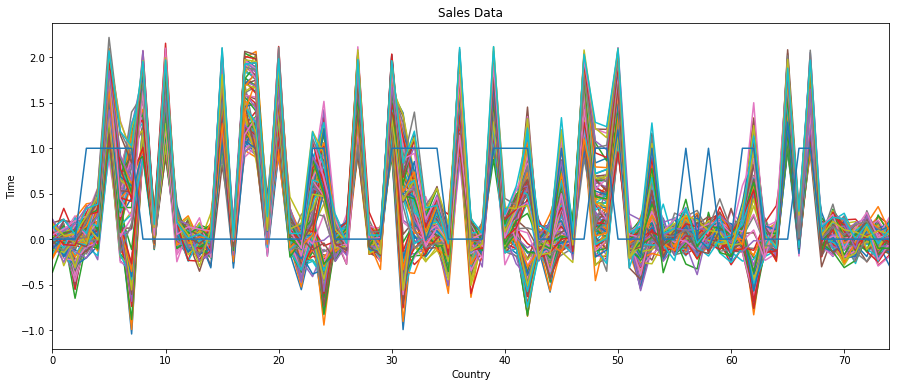

In [5]:
ax = data.loc[:, data.columns != 'Id'].plot(figsize = (15,6), title="Sales Data", legend = False)
ax.set(xlabel="Country", ylabel="Time")
plt.show()

We now plot sales data for one particular country (row) in the dataset.

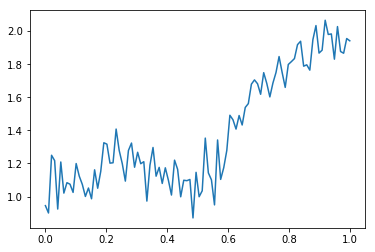

In [6]:
X = np.linspace(0,1,100)
Y = data.iloc[18,1:101].values
X = X[:, None]
Y = Y[:, None]
plt.plot(X,Y)
plt.show()

## PyMC3

Here we will utilize PyMC3 to detect and remove the seasonal component of each countries sales data if one is present.

To start we will focus on the country (row) we chose in the previous steps.

In [7]:
with pm.Model() as model:
    #  periodic component x 
    η_true  = pm.Normal("η_true", mu=0.1, sigma=3)
    ℓ_true  = pm.Normal("ℓ_true", mu=0.1, sigma=3)

    cov_seasonal = η_true**2 * pm.gp.cov.ExpQuad(1, ℓ_true) # Maybe change this to 100 since its 100 dimentions
    gp1 = pm.gp.Marginal(cov_func=cov_seasonal)

    #  linear component x 
    cov_linear = η_true**2 * pm.gp.cov.Matern32(1, ℓ_true) # Maybe change this to 100 since its 100 dimentions
    gp2 = pm.gp.Marginal(cov_func=cov_linear)

    # gp represents f1 + f2.
    gp = gp1 + gp2

    # noise model
    sigma = pm.HalfCauchy("sigma", beta=5, testval=0.1)
    f = gp.marginal_likelihood("f", X, Y[:,0], noise=sigma)

    # this line calls an optimizer to optimize the marginal likelihood
    mp = pm.find_MAP(include_transformed=True)

logp = 66.555, ||grad|| = 0.03297: 100%|██████████| 18/18 [00:00<00:00, 173.82it/s]  


In [8]:
#optimized parameters
sorted([name+":"+str(mp[name]) for name in mp.keys() if not name.endswith("_")])

['sigma:0.09646366589418474',
 'η_true:0.9217250135046413',
 'ℓ_true:0.7831299949373917']

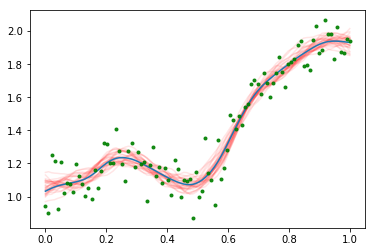

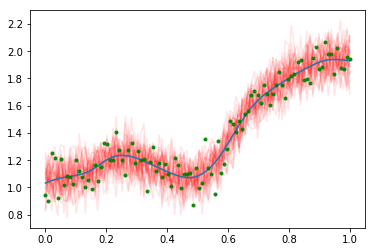

In [9]:
# 200 new values from x=0 to x=3
n_new = 100
X_new = np.linspace(0, 1, n_new)[:,None]

#periodic term
f1_pred = gp1.predict(X_new, point=mp, given={"gp": gp, "X": X, "y": Y[:,0], "noise": sigma})
y1_pred = gp1.predict(X_new, point=mp, given={"gp": gp, "X": X, "y": Y[:,0], "noise": sigma}, pred_noise=True)
#linear term
f2_pred = gp2.predict(X_new, point=mp, given={"gp": gp, "X": X, "y": Y[:,0], "noise": sigma})
y2_pred = gp2.predict(X_new, point=mp, given={"gp": gp, "X": X, "y": Y[:,0], "noise": sigma}, pred_noise=True)
#sum of periodic and linear term
y_pred  = gp.predict(X_new, point=mp, given={"gp": gp, "X": X, "y": Y[:,0], "noise": sigma}, pred_noise=True)
f_pred  = gp.predict(X_new, point=mp, given={"gp": gp, "X": X, "y": Y[:,0], "noise": sigma})

#we sample 10 regression lines from the posterior
sample_f = multivariate_normal(f_pred[0],f_pred[1]).rvs(30)

plt.plot(X_new[:,0],sample_f.T,color='red',alpha=0.1)# regression lines
plt.plot(X_new[:,0],f_pred[0])# this is the average line
plt.plot(X, Y, 'og', ms=3, alpha=0.9, label="Observed data", Zorder=1000);
plt.show()

#we sample 10 regression lines from the posterior
sample_y = multivariate_normal(y_pred[0],y_pred[1]).rvs(30)

plt.plot(X_new[:,0],sample_y.T,color='red',alpha=0.1)# regression lines
plt.plot(X_new[:,0],f_pred[0])# this is the average line
plt.plot(X, Y, 'og', ms=3, alpha=0.9, label="Observed data", Zorder=1000);
plt.show()

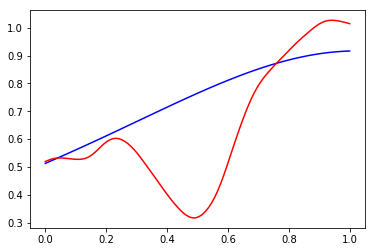

In [10]:
#we can recover the single components
plt.plot(X_new[:,0],f1_pred[0], color="blue")
plt.plot(X_new[:,0],f2_pred[0], color="red")
plt.show()

In [11]:
f2_pred[0]

array([0.51946469, 0.52392334, 0.52786946, 0.5305984 , 0.53195748,
       0.5322654 , 0.5316632 , 0.53053916, 0.52923668, 0.52807594,
       0.52732341, 0.52715397, 0.52802208, 0.53052087, 0.53512099,
       0.54194278, 0.55076178, 0.56093719, 0.57171043, 0.58202861,
       0.59079901, 0.59735818, 0.60143145, 0.60276904, 0.6011748 ,
       0.59694632, 0.59059285, 0.58245608, 0.57249989, 0.56078336,
       0.54762873, 0.53334316, 0.51835042, 0.50310973, 0.48798024,
       0.47277085, 0.45728032, 0.44165866, 0.42608674, 0.41077977,
       0.39586617, 0.38156849, 0.36804266, 0.35526444, 0.3435376 ,
       0.33340554, 0.32525785, 0.31950829, 0.31667294, 0.31723384,
       0.32119129, 0.32853167, 0.33900222, 0.35227466, 0.36862937,
       0.38849874, 0.41202221, 0.43877262, 0.46844223, 0.50038215,
       0.53356403, 0.56690758, 0.59975633, 0.63175629, 0.66258815,
       0.6919647 , 0.71946061, 0.7446406 , 0.76714602, 0.78692838,
       0.80427573, 0.81962756, 0.83338933, 0.84612299, 0.85833

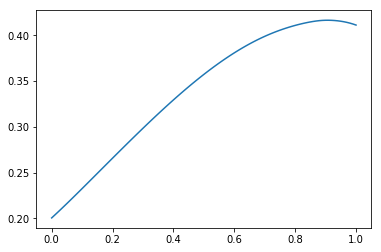

In [12]:
plt.plot(X_new[:,0],f2_pred[1][88])
plt.show()

Defining `run_model` method that we will call in a loop for each row in the dataset.

In [13]:
def run_model(x_in, y_in, plot=False):
    with pm.Model() as model:
        #  periodic component x 
        η_true  = pm.Normal("η_true", mu=0.1, sigma=3)
        ℓ_true  = pm.Normal("ℓ_true", mu=0.1, sigma=3)

        cov_seasonal = η_true**2 * pm.gp.cov.ExpQuad(1, ℓ_true) # Maybe change this to 100 since its 100 dimentions
        gp1 = pm.gp.Marginal(cov_func=cov_seasonal)

        #  linear component x 
        cov_linear = η_true**2 * pm.gp.cov.Matern32(1, ℓ_true) # Maybe change this to 100 since its 100 dimentions
        gp2 = pm.gp.Marginal(cov_func=cov_linear)

        # gp represents f1 + f2.
        gp = gp1 + gp2

        # noise model
        sigma = pm.HalfCauchy("sigma", beta=5, testval=0.1)
        f = gp.marginal_likelihood("f", x_in, y_in[:,0], noise=sigma)

        # this line calls an optimizer to optimize the marginal likelihood
        mp = pm.find_MAP(include_transformed=True)

    # 200 new values from x=0 to x=3
    n_new = 100
    X_new = np.linspace(0, 1, n_new)[:,None]

    #periodic term
    f1_pred = gp1.predict(X_new, point=mp, given={"gp": gp, "X": x_in, "y": y_in[:,0], "noise": sigma})
    y1_pred = gp1.predict(X_new, point=mp, given={"gp": gp, "X": x_in, "y": y_in[:,0], "noise": sigma}, pred_noise=True)
    #linear term
    f2_pred = gp2.predict(X_new, point=mp, given={"gp": gp, "X": x_in, "y": y_in[:,0], "noise": sigma})
    y2_pred = gp2.predict(X_new, point=mp, given={"gp": gp, "X": x_in, "y": y_in[:,0], "noise": sigma}, pred_noise=True)
    #sum of periodic and linear term
    y_pred  = gp.predict(X_new, point=mp, given={"gp": gp, "X": x_in, "y": y_in[:,0], "noise": sigma}, pred_noise=True)
    f_pred  = gp.predict(X_new, point=mp, given={"gp": gp, "X": x_in, "y": y_in[:,0], "noise": sigma})
    
    posterior_probability_deriviative_is_positive = len(np.where(np.gradient(f2_pred[0],X_new[:,0])>0)[0])/len(f2_pred[0])
    
    print("Probability Sales Increasing is: ", posterior_probability_deriviative_is_positive)
    if posterior_probability_deriviative_is_positive>0.8:
        return 1
    else:
        return 0

Loading the `test.csv` dataset.

In [14]:
test_df = pd.read_csv('./data/test.csv')
test_df.head()

,Id,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,0,1.050702,1.004361,0.880657,0.959512,1.014129,0.890916,0.986703,1.135940,1.223539,...,1.826883,1.797263,1.872348,1.926992,1.843073,1.958611,1.800846,1.867793,2.056990,2.060379
1,1,-0.042360,-0.134542,-0.093373,0.076402,-0.122659,-0.149690,-0.050888,0.087327,-0.003546,...,0.233283,0.265816,0.218283,0.134600,0.273861,0.056165,0.103871,0.099539,0.305985,0.294278
2,2,0.035063,0.050938,0.067512,0.117029,0.049060,-0.014029,0.079372,0.204120,0.002883,...,-0.005722,0.195326,0.169835,0.255006,0.211215,0.116720,0.162032,0.116356,0.305580,0.202131
3,3,-0.111408,-0.063093,-0.094206,-0.054800,-0.021415,0.083715,-0.032116,-0.158563,0.114007,...,0.074536,0.009352,-0.016270,-0.087119,0.007215,0.073824,-0.114334,0.008747,0.023304,-0.071806
4,4,0.977574,0.989015,1.243740,1.111227,1.288457,1.000790,1.052081,0.937450,0.999783,...,1.907418,1.892012,1.780125,1.899383,1.939521,1.896775,2.038367,2.071734,1.982058,2.023052


Here we define the x space as linearly distributed between 0 and 1 for 100 points. We then loop over each row in our test dataset and run the model defined above on the data.

In [15]:
x = np.linspace(0,1,100)[:,None]
Decision = pd.DataFrame(columns=['Id','Category'])
for r in range(test_df.shape[0]):
    id_row = test_df.iloc[r,0]
    y = test_df.iloc[r,1:101].values[:,None]
    decision = run_model(x,y)
    Decision = Decision.append({'Id': int(id_row), 'Category': int(decision)}, ignore_index=True)
    print(f'{r + 1}/{test_df.shape[0]} rows complete')

print(Decision)
Decision.to_csv('submission_1.csv')

logp = 70.088, ||grad|| = 0.016035: 100%|██████████| 25/25 [00:00<00:00, 257.94it/s]  


Probability Sales Increasing is:  1.0
1/120 rows complete


logp = 79.029, ||grad|| = 0.27356: 100%|██████████| 15/15 [00:00<00:00, 267.15it/s]  


Probability Sales Increasing is:  0.75
2/120 rows complete


logp = 81.088, ||grad|| = 12.25: 100%|██████████| 21/21 [00:00<00:00, 254.33it/s]  


Probability Sales Increasing is:  0.6
3/120 rows complete


logp = 83.11, ||grad|| = 4.6177: 100%|██████████| 29/29 [00:00<00:00, 239.36it/s]   


Probability Sales Increasing is:  0.51
4/120 rows complete


logp = 64.607, ||grad|| = 0.40017: 100%|██████████| 20/20 [00:00<00:00, 291.60it/s]  


Probability Sales Increasing is:  0.75
5/120 rows complete


logp = 66.709, ||grad|| = 11.903: 100%|██████████| 19/19 [00:00<00:00, 249.28it/s]  


Probability Sales Increasing is:  0.57
6/120 rows complete


logp = 72.839, ||grad|| = 0.48624: 100%|██████████| 17/17 [00:00<00:00, 277.25it/s]  


Probability Sales Increasing is:  0.8
7/120 rows complete


logp = 81.506, ||grad|| = 0.19752: 100%|██████████| 26/26 [00:00<00:00, 295.30it/s]  


Probability Sales Increasing is:  0.98
8/120 rows complete


logp = 75.192, ||grad|| = 0.00093609: 100%|██████████| 13/13 [00:00<00:00, 230.43it/s]  


Probability Sales Increasing is:  0.47
9/120 rows complete


logp = 54.919, ||grad|| = 6.0602: 100%|██████████| 28/28 [00:00<00:00, 290.06it/s]  


Probability Sales Increasing is:  0.62
10/120 rows complete


logp = 67.529, ||grad|| = 0.55685: 100%|██████████| 21/21 [00:00<00:00, 299.31it/s]  


Probability Sales Increasing is:  0.82
11/120 rows complete


logp = 70.225, ||grad|| = 0.12948: 100%|██████████| 18/18 [00:00<00:00, 280.31it/s]  


Probability Sales Increasing is:  1.0
12/120 rows complete


logp = 60.997, ||grad|| = 14.08: 100%|██████████| 20/20 [00:00<00:00, 286.99it/s]  


Probability Sales Increasing is:  0.53
13/120 rows complete


logp = 78.106, ||grad|| = 5.5721: 100%|██████████| 16/16 [00:00<00:00, 272.01it/s]  


Probability Sales Increasing is:  0.43
14/120 rows complete


logp = 66.433, ||grad|| = 0.0013202: 100%|██████████| 22/22 [00:00<00:00, 288.20it/s]  


Probability Sales Increasing is:  0.46
15/120 rows complete


logp = 83.522, ||grad|| = 1.3617: 100%|██████████| 29/29 [00:00<00:00, 269.31it/s]  


Probability Sales Increasing is:  0.95
16/120 rows complete


logp = 57.858, ||grad|| = 0.84049: 100%|██████████| 19/19 [00:00<00:00, 281.91it/s]  


Probability Sales Increasing is:  0.77
17/120 rows complete


logp = 68.784, ||grad|| = 0.0049116: 100%|██████████| 13/13 [00:00<00:00, 262.99it/s]  


Probability Sales Increasing is:  0.57
18/120 rows complete


logp = 73.61, ||grad|| = 0.20097: 100%|██████████| 14/14 [00:00<00:00, 264.02it/s]  


Probability Sales Increasing is:  0.52
19/120 rows complete


logp = 71.665, ||grad|| = 0.044518: 100%|██████████| 19/19 [00:00<00:00, 283.96it/s]  


Probability Sales Increasing is:  1.0
20/120 rows complete


logp = 71.057, ||grad|| = 5.9456e-05: 100%|██████████| 22/22 [00:00<00:00, 289.97it/s]  


Probability Sales Increasing is:  0.62
21/120 rows complete


logp = 67.511, ||grad|| = 30.582: 100%|██████████| 27/27 [00:00<00:00, 280.13it/s]  


Probability Sales Increasing is:  0.49
22/120 rows complete


logp = 77.291, ||grad|| = 26.935: 100%|██████████| 21/21 [00:00<00:00, 265.57it/s]  


Probability Sales Increasing is:  0.5
23/120 rows complete


logp = 61.696, ||grad|| = 0.00076236: 100%|██████████| 13/13 [00:00<00:00, 243.75it/s]  


Probability Sales Increasing is:  0.53
24/120 rows complete


logp = 66.086, ||grad|| = 0.007008: 100%|██████████| 13/13 [00:00<00:00, 254.72it/s]  


Probability Sales Increasing is:  0.49
25/120 rows complete


logp = 93.475, ||grad|| = 0.16638: 100%|██████████| 26/26 [00:00<00:00, 283.58it/s]  


Probability Sales Increasing is:  0.27
26/120 rows complete


logp = 64.687, ||grad|| = 0.012814: 100%|██████████| 13/13 [00:00<00:00, 219.72it/s]  


Probability Sales Increasing is:  0.52
27/120 rows complete


logp = 75.343, ||grad|| = 0.00044095: 100%|██████████| 22/22 [00:00<00:00, 251.69it/s]  


Probability Sales Increasing is:  0.88
28/120 rows complete


logp = 64.599, ||grad|| = 10.081: 100%|██████████| 20/20 [00:00<00:00, 279.00it/s]  


Probability Sales Increasing is:  0.53
29/120 rows complete


logp = 61.776, ||grad|| = 0.0058629: 100%|██████████| 24/24 [00:00<00:00, 182.38it/s]  


Probability Sales Increasing is:  1.0
30/120 rows complete


logp = 76.66, ||grad|| = 0.11049: 100%|██████████| 26/26 [00:00<00:00, 281.00it/s]  


Probability Sales Increasing is:  1.0
31/120 rows complete


logp = 73.407, ||grad|| = 0.096603: 100%|██████████| 18/18 [00:00<00:00, 244.01it/s]  


Probability Sales Increasing is:  0.91
32/120 rows complete


logp = 71.835, ||grad|| = 0.29674: 100%|██████████| 26/26 [00:00<00:00, 265.20it/s]  


Probability Sales Increasing is:  1.0
33/120 rows complete


logp = 61.755, ||grad|| = 0.016704: 100%|██████████| 26/26 [00:00<00:00, 269.73it/s]  


Probability Sales Increasing is:  1.0
34/120 rows complete


logp = 66.365, ||grad|| = 0.29754: 100%|██████████| 19/19 [00:00<00:00, 243.48it/s]  


Probability Sales Increasing is:  0.76
35/120 rows complete


logp = 58.664, ||grad|| = 0.019916: 100%|██████████| 25/25 [00:00<00:00, 226.71it/s]  


Probability Sales Increasing is:  1.0
36/120 rows complete


logp = 60.274, ||grad|| = 0.65628: 100%|██████████| 21/21 [00:00<00:00, 276.03it/s]  


Probability Sales Increasing is:  0.72
37/120 rows complete


logp = 76.007, ||grad|| = 0.0031595: 100%|██████████| 13/13 [00:00<00:00, 231.50it/s]  


Probability Sales Increasing is:  0.47
38/120 rows complete


logp = 70.802, ||grad|| = 0.44748: 100%|██████████| 19/19 [00:00<00:00, 265.26it/s]  


Probability Sales Increasing is:  0.7
39/120 rows complete


logp = 80.273, ||grad|| = 5.271: 100%|██████████| 18/18 [00:00<00:00, 242.78it/s]  


Probability Sales Increasing is:  0.65
40/120 rows complete


logp = 76.215, ||grad|| = 0.062981: 100%|██████████| 26/26 [00:00<00:00, 266.73it/s]  


Probability Sales Increasing is:  1.0
41/120 rows complete


logp = 80.982, ||grad|| = 0.28967: 100%|██████████| 26/26 [00:00<00:00, 275.96it/s]  


Probability Sales Increasing is:  0.78
42/120 rows complete


logp = 82.092, ||grad|| = 0.072551: 100%|██████████| 14/14 [00:00<00:00, 199.21it/s]  


Probability Sales Increasing is:  0.68
43/120 rows complete


logp = 79.489, ||grad|| = 0.016691: 100%|██████████| 13/13 [00:00<00:00, 205.88it/s]  


Probability Sales Increasing is:  0.58
44/120 rows complete


logp = 49.984, ||grad|| = 12.861: 100%|██████████| 21/21 [00:00<00:00, 250.24it/s]  


Probability Sales Increasing is:  0.5
45/120 rows complete


logp = 71.447, ||grad|| = 0.40535: 100%|██████████| 20/20 [00:00<00:00, 240.64it/s]  


Probability Sales Increasing is:  0.7
46/120 rows complete


logp = 65.273, ||grad|| = 0.0037152: 100%|██████████| 13/13 [00:00<00:00, 212.49it/s]  


Probability Sales Increasing is:  0.55
47/120 rows complete


logp = 77.895, ||grad|| = 1.7172: 100%|██████████| 21/21 [00:00<00:00, 271.05it/s]  


Probability Sales Increasing is:  0.78
48/120 rows complete


logp = 71.828, ||grad|| = 3.1284: 100%|██████████| 20/20 [00:00<00:00, 287.64it/s]  


Probability Sales Increasing is:  0.68
49/120 rows complete


logp = 67.24, ||grad|| = 1.0663: 100%|██████████| 19/19 [00:00<00:00, 263.90it/s]  


Probability Sales Increasing is:  0.84
50/120 rows complete


logp = 57.782, ||grad|| = 4.6381: 100%|██████████| 28/28 [00:00<00:00, 285.40it/s]  


Probability Sales Increasing is:  0.64
51/120 rows complete


logp = 60.677, ||grad|| = 0.0091052: 100%|██████████| 24/24 [00:00<00:00, 273.95it/s]  


Probability Sales Increasing is:  0.79
52/120 rows complete


logp = 72.821, ||grad|| = 0.089286: 100%|██████████| 15/15 [00:00<00:00, 211.92it/s]  


Probability Sales Increasing is:  0.76
53/120 rows complete


logp = 90.833, ||grad|| = 0.0009267: 100%|██████████| 22/22 [00:00<00:00, 275.86it/s]  


Probability Sales Increasing is:  1.0
54/120 rows complete


logp = 43.798, ||grad|| = 0.081702: 100%|██████████| 25/25 [00:00<00:00, 277.81it/s]  


Probability Sales Increasing is:  0.58
55/120 rows complete


logp = 86.218, ||grad|| = 0.065569: 100%|██████████| 14/14 [00:00<00:00, 248.13it/s]  


Probability Sales Increasing is:  0.47
56/120 rows complete


logp = 63.837, ||grad|| = 0.012047: 100%|██████████| 13/13 [00:00<00:00, 257.47it/s]  


Probability Sales Increasing is:  0.59
57/120 rows complete


logp = 66.903, ||grad|| = 0.25004: 100%|██████████| 16/16 [00:00<00:00, 252.63it/s]  


Probability Sales Increasing is:  0.47
58/120 rows complete


logp = 69.196, ||grad|| = 0.80881: 100%|██████████| 21/21 [00:00<00:00, 272.25it/s]  


Probability Sales Increasing is:  0.7
59/120 rows complete


logp = 65.894, ||grad|| = 0.27202: 100%|██████████| 20/20 [00:00<00:00, 251.75it/s]  


Probability Sales Increasing is:  0.72
60/120 rows complete


logp = 72.459, ||grad|| = 0.56107: 100%|██████████| 19/19 [00:00<00:00, 260.58it/s]  


Probability Sales Increasing is:  1.0
61/120 rows complete


logp = 51.066, ||grad|| = 0.0044444: 100%|██████████| 23/23 [00:00<00:00, 236.72it/s]  


Probability Sales Increasing is:  0.57
62/120 rows complete


logp = 67.254, ||grad|| = 0.23029: 100%|██████████| 16/16 [00:00<00:00, 228.64it/s]  


Probability Sales Increasing is:  0.54
63/120 rows complete


logp = 88, ||grad|| = 10.549: 100%|██████████| 31/31 [00:00<00:00, 248.29it/s]      


Probability Sales Increasing is:  0.97
64/120 rows complete


logp = 82.921, ||grad|| = 0.10402: 100%|██████████| 24/24 [00:00<00:00, 254.19it/s]  


Probability Sales Increasing is:  0.94
65/120 rows complete


logp = 57.162, ||grad|| = 0.021661: 100%|██████████| 24/24 [00:00<00:00, 276.23it/s]  


Probability Sales Increasing is:  0.57
66/120 rows complete


logp = 71.958, ||grad|| = 0.15978: 100%|██████████| 15/15 [00:00<00:00, 190.42it/s]  


Probability Sales Increasing is:  0.69
67/120 rows complete


logp = 57.116, ||grad|| = 1.9725: 100%|██████████| 18/18 [00:00<00:00, 236.66it/s]  


Probability Sales Increasing is:  0.61
68/120 rows complete


logp = 77.571, ||grad|| = 0.12383: 100%|██████████| 24/24 [00:00<00:00, 137.29it/s]  


Probability Sales Increasing is:  0.46
69/120 rows complete


logp = 61.966, ||grad|| = 0.62011: 100%|██████████| 20/20 [00:00<00:00, 240.60it/s]  


Probability Sales Increasing is:  0.69
70/120 rows complete


logp = 61.73, ||grad|| = 0.50891: 100%|██████████| 21/21 [00:00<00:00, 250.44it/s]  


Probability Sales Increasing is:  0.72
71/120 rows complete


logp = 73.5, ||grad|| = 0.091234: 100%|██████████| 27/27 [00:00<00:00, 197.30it/s]  


Probability Sales Increasing is:  0.87
72/120 rows complete


logp = 77.879, ||grad|| = 2.584: 100%|██████████| 30/30 [00:00<00:00, 247.63it/s]   


Probability Sales Increasing is:  0.31
73/120 rows complete


logp = 72.483, ||grad|| = 0.42485: 100%|██████████| 15/15 [00:00<00:00, 222.93it/s]  


Probability Sales Increasing is:  0.6
74/120 rows complete


logp = 77.718, ||grad|| = 3.1721: 100%|██████████| 21/21 [00:00<00:00, 235.66it/s]  


Probability Sales Increasing is:  0.56
75/120 rows complete


logp = 55.194, ||grad|| = 7.1715: 100%|██████████| 19/19 [00:00<00:00, 184.03it/s]  


Probability Sales Increasing is:  0.6
76/120 rows complete


logp = 59.172, ||grad|| = 0.11636: 100%|██████████| 20/20 [00:00<00:00, 212.80it/s]  


Probability Sales Increasing is:  0.7
77/120 rows complete


logp = 77.381, ||grad|| = 21.464: 100%|██████████| 19/19 [00:00<00:00, 262.70it/s]  


Probability Sales Increasing is:  0.52
78/120 rows complete


logp = 82.305, ||grad|| = 1.2624: 100%|██████████| 20/20 [00:00<00:00, 267.74it/s]  


Probability Sales Increasing is:  0.76
79/120 rows complete


logp = 65.947, ||grad|| = 0.12327: 100%|██████████| 15/15 [00:00<00:00, 229.42it/s]  


Probability Sales Increasing is:  0.61
80/120 rows complete


logp = 54.116, ||grad|| = 16.154: 100%|██████████| 20/20 [00:00<00:00, 268.01it/s]  


Probability Sales Increasing is:  0.51
81/120 rows complete


logp = 63.845, ||grad|| = 0.00088728: 100%|██████████| 22/22 [00:00<00:00, 266.75it/s]  


Probability Sales Increasing is:  0.8
82/120 rows complete


logp = 73.29, ||grad|| = 0.12412: 100%|██████████| 25/25 [00:00<00:00, 277.24it/s]  


Probability Sales Increasing is:  1.0
83/120 rows complete


logp = 43.673, ||grad|| = 0.95655: 100%|██████████| 26/26 [00:00<00:00, 271.11it/s]  


Probability Sales Increasing is:  0.55
84/120 rows complete


logp = 82.668, ||grad|| = 20.685: 100%|██████████| 17/17 [00:00<00:00, 207.10it/s]  


Probability Sales Increasing is:  0.52
85/120 rows complete


logp = 76.087, ||grad|| = 19.73: 100%|██████████| 18/18 [00:00<00:00, 250.84it/s]  


Probability Sales Increasing is:  0.44
86/120 rows complete


logp = 83.789, ||grad|| = 0.68673: 100%|██████████| 27/27 [00:00<00:00, 293.38it/s]  


Probability Sales Increasing is:  0.79
87/120 rows complete


logp = 75.834, ||grad|| = 0.00056672: 100%|██████████| 22/22 [00:00<00:00, 272.99it/s]  


Probability Sales Increasing is:  0.5
88/120 rows complete


logp = 61.697, ||grad|| = 0.00020881: 100%|██████████| 22/22 [00:00<00:00, 276.70it/s]  


Probability Sales Increasing is:  0.78
89/120 rows complete


logp = 42.189, ||grad|| = 4.2626: 100%|██████████| 27/27 [00:00<00:00, 220.73it/s]  


Probability Sales Increasing is:  0.53
90/120 rows complete


logp = 89.097, ||grad|| = 0.01712: 100%|██████████| 22/22 [00:00<00:00, 376.42it/s]  


Probability Sales Increasing is:  0.31
91/120 rows complete


logp = 76.396, ||grad|| = 0.060103: 100%|██████████| 19/19 [00:00<00:00, 388.76it/s]  


Probability Sales Increasing is:  1.0
92/120 rows complete


logp = 70.201, ||grad|| = 1.0297: 100%|██████████| 25/25 [00:00<00:00, 357.58it/s]  


Probability Sales Increasing is:  0.72
93/120 rows complete


logp = 91.505, ||grad|| = 0.20968: 100%|██████████| 19/19 [00:00<00:00, 383.31it/s]  


Probability Sales Increasing is:  0.81
94/120 rows complete


logp = 73.457, ||grad|| = 0.10563: 100%|██████████| 25/25 [00:00<00:00, 105.32it/s] 


Probability Sales Increasing is:  0.84
95/120 rows complete


logp = 70.798, ||grad|| = 2.5678: 100%|██████████| 18/18 [00:00<00:00, 364.57it/s]  


Probability Sales Increasing is:  0.54
96/120 rows complete


logp = 76.361, ||grad|| = 0.041442: 100%|██████████| 16/16 [00:00<00:00, 230.35it/s]  


Probability Sales Increasing is:  0.59
97/120 rows complete


logp = 66.162, ||grad|| = 1.1911: 100%|██████████| 26/26 [00:00<00:00, 312.87it/s]  


Probability Sales Increasing is:  0.6
98/120 rows complete


logp = 84.094, ||grad|| = 2.2893: 100%|██████████| 18/18 [00:00<00:00, 379.07it/s]  


Probability Sales Increasing is:  0.79
99/120 rows complete


logp = 77.635, ||grad|| = 0.0006582: 100%|██████████| 24/24 [00:00<00:00, 335.84it/s]  


Probability Sales Increasing is:  1.0
100/120 rows complete


logp = 54.595, ||grad|| = 19.709: 100%|██████████| 21/21 [00:00<00:00, 186.77it/s]  


Probability Sales Increasing is:  0.54
101/120 rows complete


logp = 66.155, ||grad|| = 0.013395: 100%|██████████| 13/13 [00:00<00:00, 90.85it/s]  


Probability Sales Increasing is:  0.47
102/120 rows complete


logp = 41.19, ||grad|| = 2.8234: 100%|██████████| 27/27 [00:00<00:00, 377.53it/s]   


Probability Sales Increasing is:  0.57
103/120 rows complete


logp = 71.588, ||grad|| = 2.4096: 100%|██████████| 21/21 [00:00<00:00, 136.52it/s]  


Probability Sales Increasing is:  0.72
104/120 rows complete


logp = 67.351, ||grad|| = 0.62094: 100%|██████████| 19/19 [00:00<00:00, 245.58it/s]  


Probability Sales Increasing is:  1.0
105/120 rows complete


logp = 79.647, ||grad|| = 5.6958: 100%|██████████| 19/19 [00:00<00:00, 246.57it/s]  


Probability Sales Increasing is:  0.63
106/120 rows complete


logp = 58.037, ||grad|| = 0.16131: 100%|██████████| 21/21 [00:00<00:00, 303.61it/s]  


Probability Sales Increasing is:  0.54
107/120 rows complete


logp = 60.002, ||grad|| = 1.2792: 100%|██████████| 20/20 [00:00<00:00, 267.40it/s]  


Probability Sales Increasing is:  0.77
108/120 rows complete


logp = 74.502, ||grad|| = 0.46038: 100%|██████████| 27/27 [00:00<00:00, 211.00it/s]  


Probability Sales Increasing is:  0.63
109/120 rows complete


logp = 68.563, ||grad|| = 5.6549e-05: 100%|██████████| 22/22 [00:00<00:00, 178.11it/s]  


Probability Sales Increasing is:  0.52
110/120 rows complete


logp = 82.167, ||grad|| = 0.024795: 100%|██████████| 25/25 [00:00<00:00, 283.13it/s]  


Probability Sales Increasing is:  1.0
111/120 rows complete


logp = 66.822, ||grad|| = 0.48575: 100%|██████████| 24/24 [00:00<00:00, 314.83it/s]  


Probability Sales Increasing is:  1.0
112/120 rows complete


logp = 53.212, ||grad|| = 0.049819: 100%|██████████| 25/25 [00:00<00:00, 367.72it/s]  


Probability Sales Increasing is:  0.57
113/120 rows complete


logp = 51.873, ||grad|| = 0.058572: 100%|██████████| 19/19 [00:00<00:00, 280.39it/s]  


Probability Sales Increasing is:  0.66
114/120 rows complete


logp = 72.595, ||grad|| = 0.0028595: 100%|██████████| 23/23 [00:00<00:00, 280.59it/s]  


Probability Sales Increasing is:  0.81
115/120 rows complete


logp = 80.444, ||grad|| = 3.6374: 100%|██████████| 29/29 [00:00<00:00, 310.41it/s]  


Probability Sales Increasing is:  1.0
116/120 rows complete


logp = 74.49, ||grad|| = 0.53124: 100%|██████████| 21/21 [00:00<00:00, 295.63it/s]  


Probability Sales Increasing is:  0.68
117/120 rows complete


logp = 74.773, ||grad|| = 0.00090703: 100%|██████████| 23/23 [00:00<00:00, 311.87it/s]  


Probability Sales Increasing is:  1.0
118/120 rows complete


logp = 60.147, ||grad|| = 0.0051496: 100%|██████████| 13/13 [00:00<00:00, 278.99it/s]  


Probability Sales Increasing is:  0.55
119/120 rows complete


logp = 58.596, ||grad|| = 0.88226: 100%|██████████| 21/21 [00:00<00:00, 243.82it/s]  


Probability Sales Increasing is:  0.81
120/120 rows complete
      Id Category
0      0        1
1      1        0
2      2        0
3      3        0
4      4        0
5      5        0
6      6        0
7      7        1
8      8        0
9      9        0
10    10        1
11    11        1
12    12        0
13    13        0
14    14        0
15    15        1
16    16        0
17    17        0
18    18        0
19    19        1
20    20        0
21    21        0
22    22        0
23    23        0
24    24        0
25    25        0
26    26        0
27    27        1
28    28        0
29    29        1
..   ...      ...
90    90        0
91    91        1
92    92        0
93    93        1
94    94        1
95    95        0
96    96        0
97    97        0
98    98        0
99    99        1
100  100        0
101  101        0
102  102        0
103  103        0
104  104        1
105  105        0
106  106        0
107  107        0
108  108        0
109  109        0
110

## GPy

Here we move away from PyMC3 and use another PML package called GPy. We compare how both performed on the Sales data.

Optimization restart 1/5, f = 8.265556722461234
Optimization restart 2/5, f = 64.15917424264222
Optimization restart 3/5, f = 8.265557794438813
Optimization restart 4/5, f = 177.6991492030139
Optimization restart 5/5, f = 6.322201168469768


GP_regression.,value,constraints,priors
mul.ExpQuad.variance,612.9490548081377,+ve,
mul.ExpQuad.lengthscale,0.5711259114132264,+ve,
mul.periodic_exponential.variance,335.07204109615157,+ve,
mul.periodic_exponential.lengthscale,21596.445108516575,+ve,
mul.periodic_exponential.period,5.297462677791528,+ve,
mul.linear.variances,334.67313742485726,+ve,
Gaussian_noise.variance,0.033443541988480006,+ve,


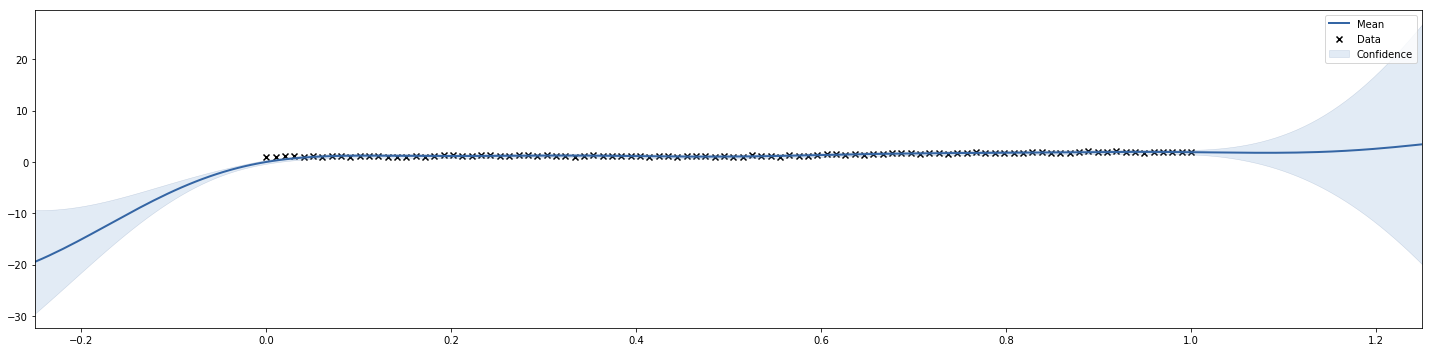

In [16]:
import GPy as GPy

#RBF
ker1 = GPy.kern.ExpQuad(1)
#Periodic
ker2 = GPy.kern.PeriodicExponential(1, period=6) 
#Polynomial of degree 6
ker3 = GPy.kern.Linear(1) 

kernel = ker1*ker2*ker3

# create a GP model
g_model = GPy.models.GPRegression(X,Y,kernel=kernel)

# it finds the optimal parameters of the RBF kernel by maxisiming the marginal likelihood 
g_model.optimize_restarts(5)# this maximise the marginal likelihood, with random restarts
#we  plot it
fig = g_model.plot(figsize=(20,5))
display(g_model)

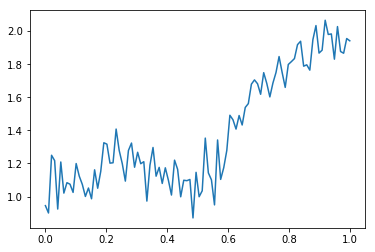

In [18]:
X = np.linspace(0,1,100)
Y = data.iloc[18,1:101].values
X = X[:, None]
Y = Y[:, None]
plt.plot(X,Y)
plt.show()

In [19]:
X_test = X
X_test = X_test.reshape(-1,1)

In [20]:
f2_pred, sigm2_pred = g_model.predict(X_test, kern=kernel)

In [21]:
posterior_probability_deriviative_is_positive = len(np.where(np.gradient(f2_pred[:,0],X_test[:,0])>0)[0])/len(f2_pred[:,0])
    
print("Probability Sales Increasing is: ", posterior_probability_deriviative_is_positive)
if posterior_probability_deriviative_is_positive>0.8:
    print("1")
else:
    print("0")

Probability Sales Increasing is:  0.69
0


In [22]:
data['Category'][0]

0

# Notes
* Test 1 - Used RBF & Matern32
 * Definitely don't use RBF as selected kernel
 * Removing linespace=100 improved the accuracy to 0.6 selecting Matern32
* Test 2 - Used RBF & Poly order = 3. Selected Poly
 * Worse - dropped to 0.5
* Test 3 - Used RBF & PeriodicExponential. Selected PeriodicExponential
 * Improved to 0.75
 * Increased to predict against 30 countries from 20 - Reduced to 73
 * Increased to predict against 50 countries from 30 - Reduced to 68
 * Increased optimize restarts from 5 to 10 - No change still 66
* Test 4 - RBF, PeriodicExponential, White
 * Had zero effect - probably because white looks like a zero based function
* Test 5 - ExpQuad, PeriodicExponential, Matern52. Selected ExpQuad
 * Typical 60% accuracy
* Test 6 - RBF, PeriodicExponential, Poly
 * Typical 60%
* Test 7 - ExpQuad, PeriodicMatern52, Linear, Poly
 * Thinking here was that a linear function may help identify the trend without the noise affecting it
 * Not sure exactly why I'm thinking this
 * didn't work, promising at smaller numbers of samples, got worse as I increased number of countries

In [23]:
rows = data.shape[0] - 45
actual = data.head(rows)['Category']

print(data.shape)
print(rows)
print(actual.shape[0])

(75, 102)
30
30


In [118]:
def run_model_2(x_in, y_in):
    ker1 = GPy.kern.RBF(1) * GPy.kern.MLP(1)
#     ker1 = GPy.kern.ExpQuad(1)
#     ker1 = GPy.kern.MLP(1)
    ker2 = GPy.kern.PeriodicMatern52(1) * GPy.kern.PeriodicExponential(1)
    ker3 = GPy.kern.Linear(1)
#     ker4 = GPy.kern.PeriodicExponential(1)
#     ker4 = GPy.kern.PolynomialBasisFuncKernel(1, 3)

    kernel = ker1+ker2+ker3#ker1+ker2+ker3+ker4

    # create a GP model
    g_model = GPy.models.GPRegression(x_in,y_in,kernel=kernel)

    # it finds the optimal parameters of the RBF kernel by maxisiming the marginal likelihood 
    g_model.optimize_restarts(5)# this maximise the marginal
    
    X_test = x
    X_test = X_test.reshape(-1,1)
    
    f2_pred, sigm2_pred = g_model.predict(X_test, kern=ker3)
    
    plt.plot(x_in[:,0],f2_pred)
    plt.show()
    
    posterior_probability_deriviative_is_positive = len(np.where(np.gradient(f2_pred[:,0],X_test[:,0])>0)[0])/len(f2_pred[:,0])
    
    #print("Probability Sales Increasing is: ", posterior_probability_deriviative_is_positive)
    if posterior_probability_deriviative_is_positive>0.8:
        return 1
    else:
        return 0

Iteration: 0 of 30
Optimization restart 1/5, f = -85.5731096105784
Optimization restart 2/5, f = -85.57310984965265
Optimization restart 3/5, f = -85.57310107473222
Optimization restart 4/5, f = -85.60274844175922
Optimization restart 5/5, f = -85.57310369170077


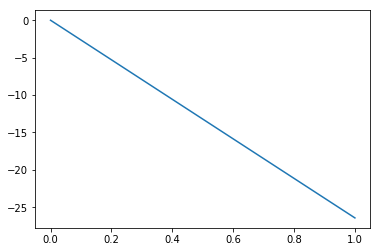

Iteration: 1 of 30
Optimization restart 1/5, f = -85.53395714787331
Optimization restart 2/5, f = -87.19841567633222
Optimization restart 3/5, f = -87.21533360389634
Optimization restart 4/5, f = -88.15098574132358
Optimization restart 5/5, f = -85.16483676211858


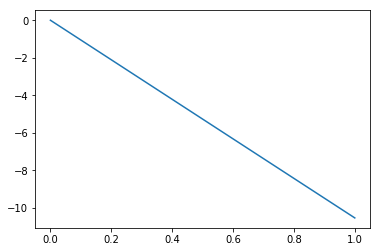

Iteration: 2 of 30
Optimization restart 1/5, f = -79.75875986353768
Optimization restart 2/5, f = -79.03772613417038
Optimization restart 3/5, f = -80.08160974603508
Optimization restart 4/5, f = -78.89885470422186
Optimization restart 5/5, f = -80.07964388767346


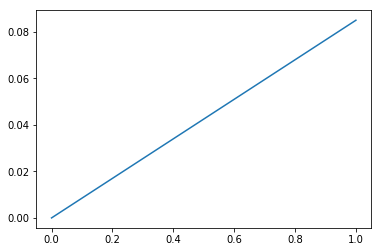

Iteration: 3 of 30
Optimization restart 1/5, f = -85.85899890702701
Optimization restart 2/5, f = -84.71192201817935
Optimization restart 3/5, f = -85.10661077422617
Optimization restart 4/5, f = -87.67528959392871
Optimization restart 5/5, f = -85.71808874383416


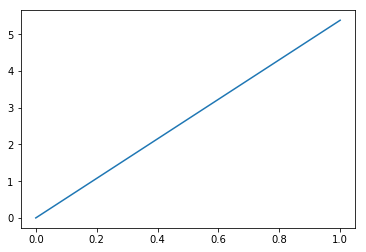

Iteration: 4 of 30
Optimization restart 1/5, f = -90.66651977359678
Optimization restart 2/5, f = -90.66651710309577
Optimization restart 3/5, f = -90.66628113911663
Optimization restart 4/5, f = -90.66640085811137
Optimization restart 5/5, f = -90.66614824592624


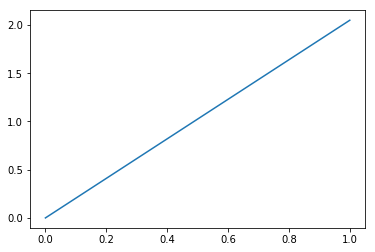

Iteration: 5 of 30
Optimization restart 1/5, f = -74.57046739002135
Optimization restart 2/5, f = -75.33548760137793
Optimization restart 3/5, f = -74.5728714441766
Optimization restart 4/5, f = -74.57283778558724
Optimization restart 5/5, f = -75.33277603244285


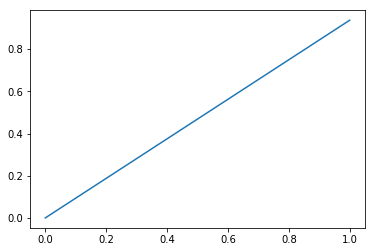

Iteration: 6 of 30
Optimization restart 1/5, f = -70.29905893918126
Optimization restart 2/5, f = -80.1328169795279
Optimization restart 3/5, f = -70.59274954047578
Optimization restart 4/5, f = -70.35038886290644
Optimization restart 5/5, f = -70.29935259900702


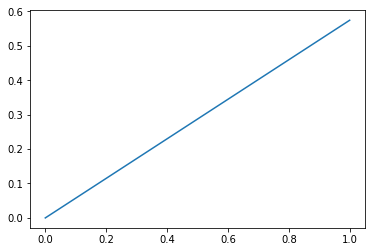

Iteration: 7 of 30
Optimization restart 1/5, f = -75.7516020424589
Optimization restart 2/5, f = -73.08381571839865
Optimization restart 3/5, f = -73.08399284338996
Optimization restart 4/5, f = -73.08387296125736
Optimization restart 5/5, f = -73.08401370127021


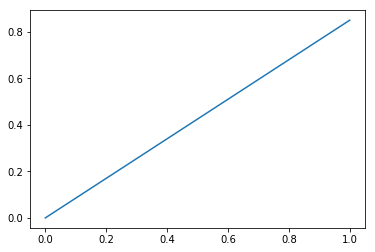

Iteration: 8 of 30
Optimization restart 1/5, f = -70.64641194689753
Optimization restart 2/5, f = -69.41425332468741
Optimization restart 3/5, f = -68.29775166104119
Optimization restart 4/5, f = -66.71886594388016
Optimization restart 5/5, f = -72.1097335060632


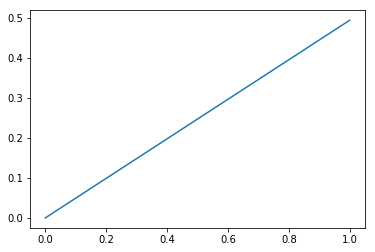

Iteration: 9 of 30
Optimization restart 1/5, f = -104.42954729112213
Optimization restart 2/5, f = -105.75099105945836
Optimization restart 3/5, f = -106.1173172403135
Optimization restart 4/5, f = -106.11732097922129
Optimization restart 5/5, f = -105.75109241813661


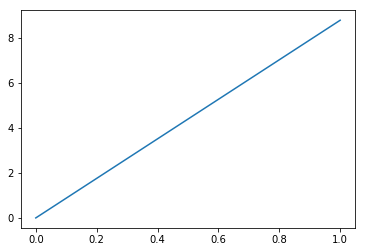

Iteration: 10 of 30
Optimization restart 1/5, f = -66.19183638210785
Optimization restart 2/5, f = -65.93360662451144
Optimization restart 3/5, f = -64.818525783133
Optimization restart 4/5, f = -66.04551110562916
Optimization restart 5/5, f = -63.48174962855991


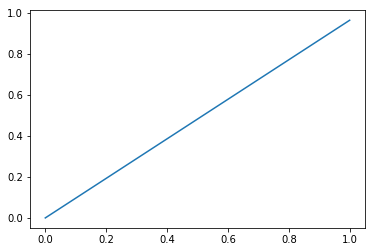

Iteration: 11 of 30
Optimization restart 1/5, f = -88.31611429792973
Optimization restart 2/5, f = -89.30710357970352
Optimization restart 3/5, f = -88.69232972001546
Optimization restart 4/5, f = -88.38219733613884
Optimization restart 5/5, f = -88.67422587994065


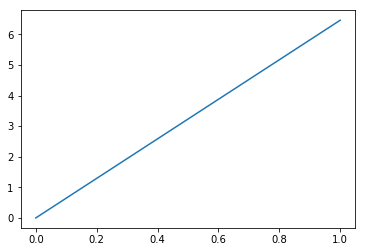

Iteration: 12 of 30
Optimization restart 1/5, f = -88.4096113509909
Optimization restart 2/5, f = -89.99312449571454
Optimization restart 3/5, f = -88.40961373248922
Optimization restart 4/5, f = -88.40960415666926
Optimization restart 5/5, f = -89.67100101150447


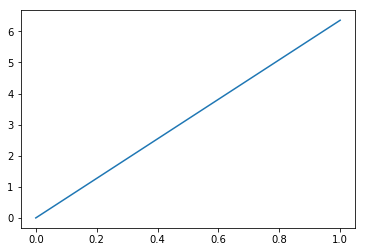

Iteration: 13 of 30
Optimization restart 1/5, f = -83.00973919788332
Optimization restart 2/5, f = -84.56022083817328
Optimization restart 3/5, f = -84.43897968761968
Optimization restart 4/5, f = -84.86264647847884
Optimization restart 5/5, f = -84.36275745069622


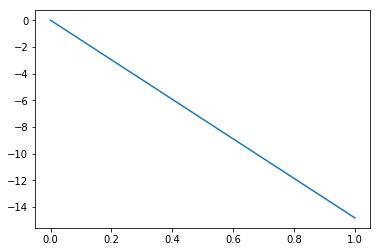

Iteration: 14 of 30
Optimization restart 1/5, f = -83.70180853065992
Optimization restart 2/5, f = -81.9199497217202
Optimization restart 3/5, f = -84.0755473289996
Optimization restart 4/5, f = -83.57879817710464
Optimization restart 5/5, f = -81.92004515277223


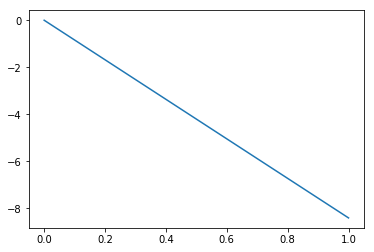

Iteration: 15 of 30
Optimization restart 1/5, f = -73.30554633450473
Optimization restart 2/5, f = -73.29229864546656
Optimization restart 3/5, f = -68.97786645594256
Optimization restart 4/5, f = -71.89176674523569
Optimization restart 5/5, f = -68.9779869938039


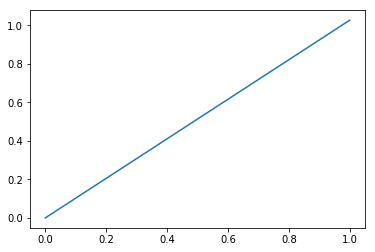

Iteration: 16 of 30
Optimization restart 1/5, f = -73.25266537047484
Optimization restart 2/5, f = -79.8282445730404
Optimization restart 3/5, f = -78.2740145426868
Optimization restart 4/5, f = -77.88325591674828
Optimization restart 5/5, f = -73.25266644392337


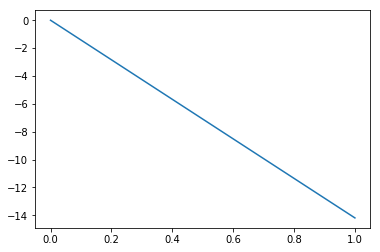

Iteration: 17 of 30
Optimization restart 1/5, f = -68.92721990853511
Optimization restart 2/5, f = -68.40860119977717
Optimization restart 3/5, f = -68.47665017142283
Optimization restart 4/5, f = -67.94371561223363
Optimization restart 5/5, f = -64.33713222936315


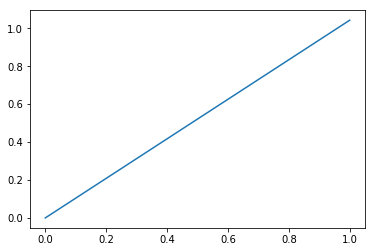

Iteration: 18 of 30
Optimization restart 1/5, f = -74.17009287611731
Optimization restart 2/5, f = -71.23849522043955
Optimization restart 3/5, f = -73.42976871942054
Optimization restart 4/5, f = -73.18615906866367
Optimization restart 5/5, f = -70.31072039663019


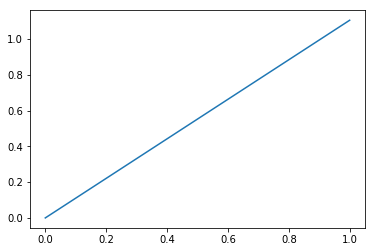

Iteration: 19 of 30
Optimization restart 1/5, f = -72.84702201398437
Optimization restart 2/5, f = -77.8835188814616
Optimization restart 3/5, f = -72.67665211573417
Optimization restart 4/5, f = -72.76553129402734
Optimization restart 5/5, f = -72.765531372639


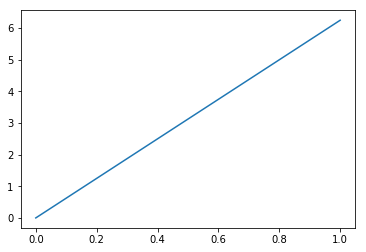

Iteration: 20 of 30
Optimization restart 1/5, f = -71.48408804540132
Optimization restart 2/5, f = -68.89147976530299
Optimization restart 3/5, f = -68.94802812503283
Optimization restart 4/5, f = -70.82836662766896
Optimization restart 5/5, f = -69.61499761816168


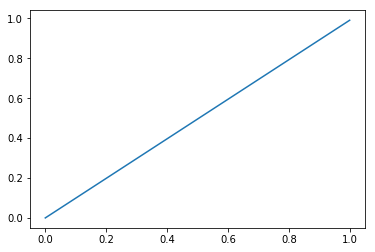

Iteration: 21 of 30
Optimization restart 1/5, f = -77.35476891432864
Optimization restart 2/5, f = -76.76172055191074
Optimization restart 3/5, f = -77.36290777356187
Optimization restart 4/5, f = -77.44445927517256
Optimization restart 5/5, f = -76.86732593851113


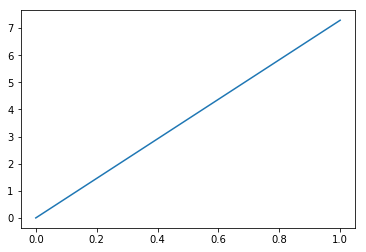

Iteration: 22 of 30
Optimization restart 1/5, f = -88.73281117736752
Optimization restart 2/5, f = -86.0577830435061
Optimization restart 3/5, f = -90.01688065514111
Optimization restart 4/5, f = -89.67415272042709
Optimization restart 5/5, f = -90.42534666586836


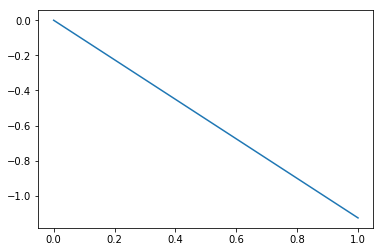

Iteration: 23 of 30
Optimization restart 1/5, f = -53.173861045160066
Optimization restart 2/5, f = -53.17404342070481
Optimization restart 3/5, f = -53.36949718725473
Optimization restart 4/5, f = -53.205784752212224
Optimization restart 5/5, f = -53.16688992237553


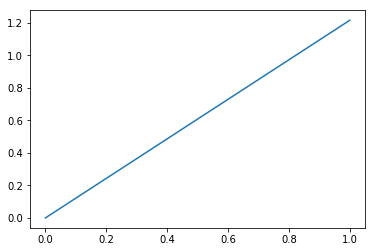

Iteration: 24 of 30
Optimization restart 1/5, f = -66.72146304308782
Optimization restart 2/5, f = -64.55229150276178
Optimization restart 3/5, f = -64.55229213696092
Optimization restart 4/5, f = -67.34974980185967
Optimization restart 5/5, f = -64.55229188741752


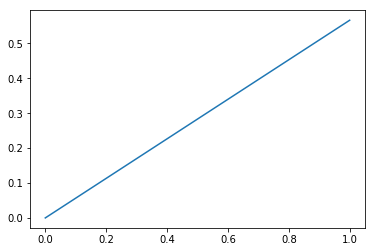

Iteration: 25 of 30
Optimization restart 1/5, f = -83.28494582555727
Optimization restart 2/5, f = -73.04317081383772
Optimization restart 3/5, f = -82.47360850222992
Optimization restart 4/5, f = -86.35179033151564
Optimization restart 5/5, f = -82.5371595316127


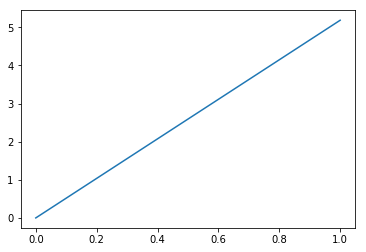

Iteration: 26 of 30
Optimization restart 1/5, f = -89.38398652213851
Optimization restart 2/5, f = -91.03885000538571
Optimization restart 3/5, f = -90.50457559112868
Optimization restart 4/5, f = -89.38401494915635
Optimization restart 5/5, f = -89.444584051142


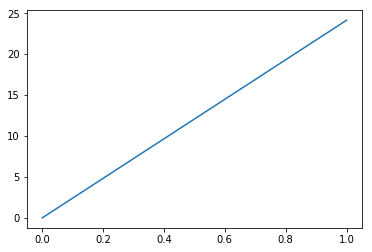

Iteration: 27 of 30
Optimization restart 1/5, f = -84.84269855856024
Optimization restart 2/5, f = -80.85715664175919
Optimization restart 3/5, f = -80.85715498219444
Optimization restart 4/5, f = -80.85715471431851
Optimization restart 5/5, f = -84.93540375632026


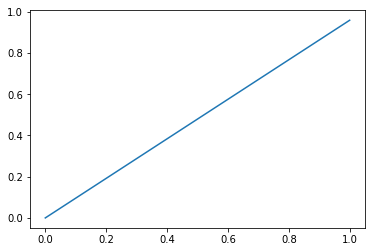

Iteration: 28 of 30
Optimization restart 1/5, f = -98.57700516657303
Optimization restart 2/5, f = -99.3808702972618
Optimization restart 3/5, f = -100.06663056506221
Optimization restart 4/5, f = -99.49154619857148
Optimization restart 5/5, f = -98.57699853284694


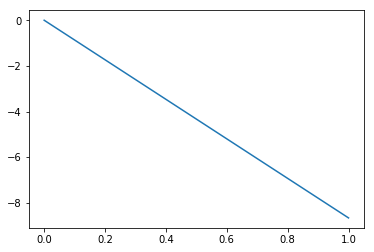

Iteration: 29 of 30
Optimization restart 1/5, f = -90.99164394915923
Optimization restart 2/5, f = -91.05178741885042
Optimization restart 3/5, f = -91.84604978603706
Optimization restart 4/5, f = -91.08801171265509
Optimization restart 5/5, f = -91.02196980377153


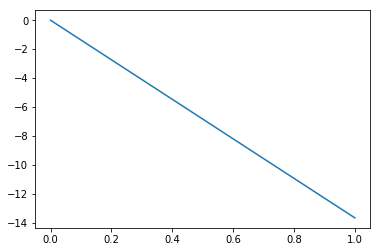

[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0]


In [119]:
x = np.linspace(0,1,100).reshape(-1,1)
# Decision = pd.DataFrame(columns=['Id','Category'])
predicted = []
for r in range(rows):
    print(f'Iteration: {r} of {rows}')
    id_row = data.iloc[r,0]
    y = data.iloc[r,1:101].values[:,None]
    decision = run_model_2(x,y)
    predicted.append(decision)
#     Decision = Decision.append({'Id': int(id_row), 'Category': int(decision)}, ignore_index=True) 
#     print(Decision)

# Decision.to_csv('submission_1.csv')
print(predicted)

In [120]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

act_col = actual.values.reshape(-1, 1)
pred_col = np.array(predicted).reshape(-1, 1)
combined = pd.DataFrame(data=np.c_[act_col, pred_col], columns=['actual', 'predicted'])
combined

# print(actual)
# print(predicted)

,actual,predicted
0,0,0
1,0,0
2,0,1
3,1,1
4,1,1
5,1,1
6,1,1
7,1,1
8,0,1
9,0,1


### Results

In [121]:
print(f'Confusion Matrix:\n{confusion_matrix(actual, predicted)}\n')
print(f'Accuracy Score:\n{accuracy_score(actual, predicted)}\n')
print ('Classification Report:')
print (classification_report(actual, predicted))

Confusion Matrix:
[[ 8 15]
 [ 0  7]]

Accuracy Score:
0.5

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.35      0.52        23
           1       0.32      1.00      0.48         7

   micro avg       0.50      0.50      0.50        30
   macro avg       0.66      0.67      0.50        30
weighted avg       0.84      0.50      0.51        30



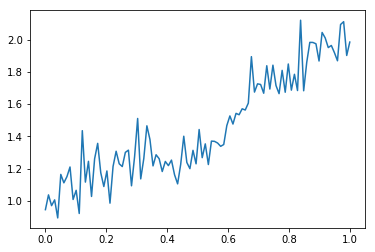

In [122]:
# Plot row that classified incorrectly
plt.plot(np.linspace(0,1,100)[:, None], data.iloc[20,1:101].values[:, None])
plt.show()